In [71]:
#imports
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms, datasets

import matplotlib.pyplot as plt
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import f1_score, accuracy_score
import cv2
import numpy as np
import os, shutil
import time
from collections import defaultdict
from matplotlib.image import imread

import torch.nn.functional as F

In [7]:
# Define CNN architecture classes
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(32 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

class DeepCNN(nn.Module):
    def __init__(self):
        super(DeepCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(128 * 4 * 4, 256) #old, replaced below
        #self.fc1 = nn.Linear(64 * 4 * 4, 128) #old, replaced below
        self.prelu = nn.PReLU() 
        #self.fc2 = nn.Linear(256, 10)
        self.fc2 = nn.Linear(256, 2)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = self.prelu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=1)

In [73]:
#pytorch configs
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
num_epochs = 3 #25 #how many of training cycles to run?
batch_size = 1000 #how many records at one time?
learning_rate = 0.001 #0.0001 how fast can you learn? size of the learning step? 0.01 was the best last time
iter_save = 10 #25

# lambda function
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(32)
    #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    #transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

In [153]:
# Functions

#Training the model
def train_model(model, train_loader):
    global loader_map
    results = { loader_name: defaultdict(list) for loader_name in loader_map }
    
    model.train()
    
    running_loss = 0.0
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(train_loader):
            #labels are the actual values of the images
            images, labels = images.to(device), labels.to(device)
            # Forward pass
            #outputs are the logits of the predicted values of the images 
            outputs = model(images)
            loss = criterion(outputs, labels)
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if (i+1)%iter_save == 0:
                #train_f1, train_acc, train_loss = test_model(model, train_loader)
                print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {running_loss/iter_save:.4f}")
                running_loss = 0.0

                for loader_name in loader_map:
                    f1, acc, loss = test_model(model, loader_map[loader_name])
                    results[loader_name]['f1'].append(f1)
                    results[loader_name]['acc'].append(acc)
                    results[loader_name]['loss'].append(loss)
                    
    #print(results)
    return results

# Testing the model
def test_model(model, data_loader):
    pred = []
    act = []
    running_loss = 0.0
    model.eval()
    with torch.no_grad():
        for images, labels in data_loader: 
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, pred_class = torch.max(outputs.data, 1)
            
            pred.append(pred_class)
            act.append(labels)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * labels.size(0)

        pred = np.concatenate(pred)
        act = np.concatenate(act)
        # f1 scores
        f1 = f1_score(act, pred, average='weighted')
        # accuracies
        acc = accuracy_score(act, pred, normalize=True)
        # loss
        loss = running_loss/len(data_loader.dataset)
            
    return f1, acc, loss

#plot performance of the models against all datasets in the global data loader map
def plotPerformance(metric, lr, iter):
    loader_name_list = []
    max_len = max([len(results[loader][metric]) for loader in results])
    x_list = np.arange(0, iter*(max_len), iter)
    for loader in results:
        y_list = results[loader][metric]
        loader_name_list.append(loader)
        plt.plot(x_list, y_list)
    plt.legend(loader_name_list, loc="lower right", bbox_to_anchor=(1.0, 1.05))
    plt.xlabel('iterations')
    plt.ylabel(f'{metric} scores')
    plt.xticks(x_list[::20], rotation=90) # Show every second label
    plt.tight_layout()
    #plt.xticks(x_list, rotation=90)
    plt.title(f'{metric} vs iterations for learning rate {lr}')
    plt.show() 
    print (np.hstack((x_list, y_list)))

def save_model(model, rel_file_path):
    #example: "model/CIFAR_real_deepNN.pth")
    torch.save(model, rel_file_path)

def get_model(rel_file_path):
   #Load the saved model
    model = torch.load(rel_file_path, weights_only=False)
    model.eval()
    return model

#move files into directories with labels (used for CIFAKE)
def moveFiles(dir_path):
    #Call syntax: moveFiles("data/archive/train/FAKE/")
    dir = os.fsdecode(dir_path)
    if not os.path.isdir(dir_path):
        print("is not directory. sad!")
        return

    #creating new number directories
    for i in range(1, 11):
        dst = os.path.join(dir_path, str(i))
        os.mkdir(dst)
        
    #for labels 2 to 10
    for file in os.listdir(dir):
        file_src = os.fsdecode(file)
        for i in range(2, 11):
            if file_src.endswith(f"({i}).jpg"):
                src = os.path.join(dir_path, file_src)
                dst = os.path.join(dir_path, str(i))
                shutil.move(src, dst)
                
    #for label 1
    for file in os.listdir(dir):
        file_src = os.fsdecode(file)
        if file_src.endswith(".jpg"):
            src = os.path.join(dir_path, file_src)
            dst = os.path.join(dir_path, "1")
            shutil.move(src, dst)

def create_ela(img):
    """ This creates a new image that contains the ELA of an image by saving it as jpg with different quality and
    then retrieve a weighted absolute differentce between the original and saved image
    Keyword arguments:img -- image to be analyzed for Error Level Analysis
    """

    img = img.astype(np.uint8)
    check = cv2.imwrite("temp.jpg", img, [cv2.IMWRITE_JPEG_QUALITY, 95])
    img2 = cv2.imread("temp.jpg")
    check = cv2.imwrite("temp.jpg", img2, [cv2.IMWRITE_JPEG_QUALITY, 90])
    img2 = cv2.imread("temp.jpg")
    diff = cv2.absdiff(img, img2)
    return diff

    

def convert_files(old_dir_path, new_dir_path):
    if not os.path.isdir(old_dir_path):
        print("is not directory. sad!")
        return
        
    if not os.path.isdir(new_dir_path):
        print("create new directory path first with 0 and 1 sub folders!")
        return
    
    #convert files
    dir = os.fsdecode(old_dir_path)
    for file in os.listdir(dir):
        try:
            src = cv2.imread(os.path.join(dir, file))
            new_file = create_ela(src)
            dst = os.path.join(new_dir_path, file)
            cv2.imwrite(dst, new_file)
        except:
            print(file)
            continue
        

def addLoader(loader_name, dir, format):
    global loader_map
    is_train = "train" in loader_name
    if format == "CIFAKE":
        dataset = torchvision.datasets.ImageFolder(root=dir, transform=transform)
        loader = torch.utils.data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=is_train)
        moveFiles(dir)
        
    elif format == "CIFAR":
        dataset = torchvision.datasets.CIFAR10(root=dir, train=is_train, download=True, transform=transform)
        loader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=is_train)
        
    loader_map[loader_name] = loader

### LOAD DATA TO TRAIN THE MODEL 

In [93]:
#data loads
#train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
#test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
#fk_test_dataset = torchvision.datasets.ImageFolder(root='./data/archive/test/FAKE', transform=transform)
#fk_train_dataset = torchvision.datasets.ImageFolder(root='./data/archive/train/FAKE', transform=transform)
#rl_train_dataset = torchvision.datasets.ImageFolder(root='./data/archive/train/REAL', transform=transform)
#rl_test_dataset = torchvision.datasets.ImageFolder(root='./data/archive/test/REAL', transform=transform)
bnry_train_dataset = torchvision.datasets.ImageFolder(root='./data/archive/train', transform=transform)
bnry_test_dataset = torchvision.datasets.ImageFolder(root='./data/archive/test', transform=transform)

#train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
#test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)
#fake_test_loader = torch.utils.data.DataLoader(dataset=fk_test_dataset, batch_size=batch_size, shuffle=True)
#fake_train_loader = torch.utils.data.DataLoader(dataset=fk_train_dataset, batch_size=batch_size, shuffle=True)
#real_train_loader = torch.utils.data.DataLoader(dataset=rl_train_dataset, batch_size=batch_size, shuffle=True)
#real_test_loader = torch.utils.data.DataLoader(dataset=rl_test_dataset, batch_size=batch_size, shuffle=True)
bnry_train_loader = torch.utils.data.DataLoader(dataset=bnry_train_dataset, batch_size=batch_size, shuffle=True)
bnry_test_loader = torch.utils.data.DataLoader(dataset=bnry_test_dataset, batch_size=batch_size, shuffle=True)

# define global map of loader_name to data loaders
loader_map = {
    #"CIFAR_test": test_loader,
    #"CIFAR_train": train_loader,
    #"CIFAKE_fake_test": fake_test_loader,
    #"CIFAKE_fake_train": fake_train_loader,
    #"CIFAKE_real_test": real_test_loader,
    #"CIFAKE_real_train": real_train_loader,
    "BNRY_test": bnry_test_loader,
    "BNRY_train": bnry_train_loader
}

In [95]:
#How many records in train folder?
bnry_train_loader.dataset, \
bnry_train_loader.dataset.classes, \
bnry_train_loader.dataset.targets.count(0), \
bnry_train_loader.dataset.targets.count(1)

(Dataset ImageFolder
     Number of datapoints: 100000
     Root location: ./data/archive/train
     StandardTransform
 Transform: Compose(
                ToTensor()
                Resize(size=32, interpolation=bilinear, max_size=None, antialias=True)
            ),
 ['0', '1'],
 50000,
 50000)

In [97]:
#How many records in test folder
bnry_test_loader.dataset, \
bnry_test_loader.dataset.classes, \
bnry_test_loader.dataset.targets.count(0), \
bnry_test_loader.dataset.targets.count(1)

(Dataset ImageFolder
     Number of datapoints: 20000
     Root location: ./data/archive/test
     StandardTransform
 Transform: Compose(
                ToTensor()
                Resize(size=32, interpolation=bilinear, max_size=None, antialias=True)
            ),
 ['0', '1'],
 10000,
 10000)

0
3072
(32, 32, 3)


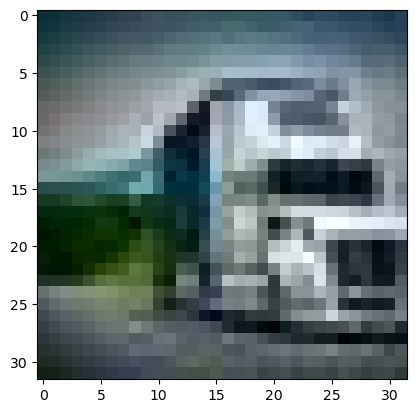

In [69]:
## LOOK AT 1 PICTURE FROM THE TEST DATA

samp_img_path, samp_label = bnry_test_loader.dataset.imgs[0]
image = imread(samp_img_path)
plt.imshow(image)

print(samp_label)
print(image.size)
print(image.shape)

In [109]:
for test_images, test_labels in bnry_test_loader:  
    sample_image = test_images[0]    
    sample_label = test_labels[0]

print(sample_image.shape)
print(sample_label)

torch.Size([3, 32, 32])
tensor(0)


### DEFINE MODEL

In [138]:
model = DeepCNN().to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

### TRAINING

In [15]:
# Select the model
#model = SimpleCNN().to(device)
start_time = time.time()

results = train_model(model, bnry_train_loader)
end_time = time.time()
elapsed_time_seconds = end_time - start_time
elapsed_time_hours = elapsed_time_seconds / 3600

print(f"Elapsed time: {elapsed_time_hours} hours")

Epoch [1/3], Step [10/100], Loss: 0.6736
Epoch [1/3], Step [20/100], Loss: 0.5793
Epoch [1/3], Step [30/100], Loss: 0.5459
Epoch [1/3], Step [40/100], Loss: 0.5262
Epoch [1/3], Step [50/100], Loss: 0.5118
Epoch [1/3], Step [60/100], Loss: 0.5019
Epoch [1/3], Step [70/100], Loss: 0.4861
Epoch [1/3], Step [80/100], Loss: 0.4779
Epoch [1/3], Step [90/100], Loss: 0.4672
Epoch [1/3], Step [100/100], Loss: 0.4599
Epoch [2/3], Step [10/100], Loss: 0.4507
Epoch [2/3], Step [20/100], Loss: 0.4410
Epoch [2/3], Step [30/100], Loss: 0.4349
Epoch [2/3], Step [40/100], Loss: 0.4400
Epoch [2/3], Step [50/100], Loss: 0.4269
Epoch [2/3], Step [60/100], Loss: 0.4213
Epoch [2/3], Step [70/100], Loss: 0.4239
Epoch [2/3], Step [80/100], Loss: 0.4246
Epoch [2/3], Step [90/100], Loss: 0.4243
Epoch [2/3], Step [100/100], Loss: 0.4131
Epoch [3/3], Step [10/100], Loss: 0.4062
Epoch [3/3], Step [20/100], Loss: 0.4139
Epoch [3/3], Step [30/100], Loss: 0.4113
Epoch [3/3], Step [40/100], Loss: 0.4096
Epoch [3/3], S

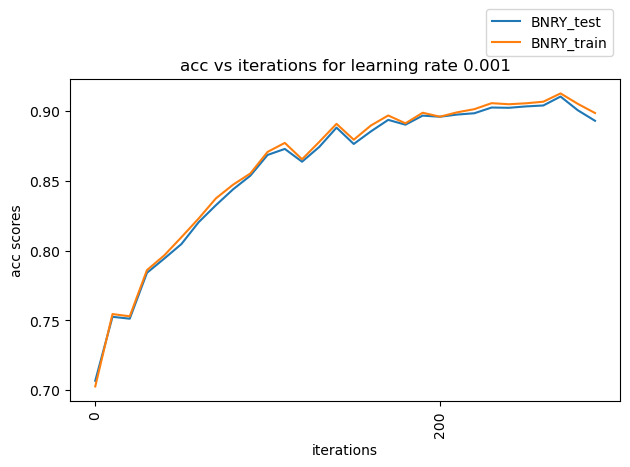

[  0.       10.       20.       30.       40.       50.       60.
  70.       80.       90.      100.      110.      120.      130.
 140.      150.      160.      170.      180.      190.      200.
 210.      220.      230.      240.      250.      260.      270.
 280.      290.        0.70274   0.75457   0.75295   0.78603   0.79654
   0.8096    0.823     0.83739   0.84722   0.85524   0.87069   0.87712
   0.8654    0.87786   0.89076   0.8794    0.88962   0.89675   0.89114
   0.89871   0.89587   0.89901   0.90128   0.90556   0.9048    0.90548
   0.90661   0.91255   0.90509   0.89851]


In [17]:
#ORIG DATASET LR 0.0001 - Adam optimizer with 20 epochs, 500 batch, and RELU, 2 classes
plotPerformance('acc', learning_rate, iter_save)

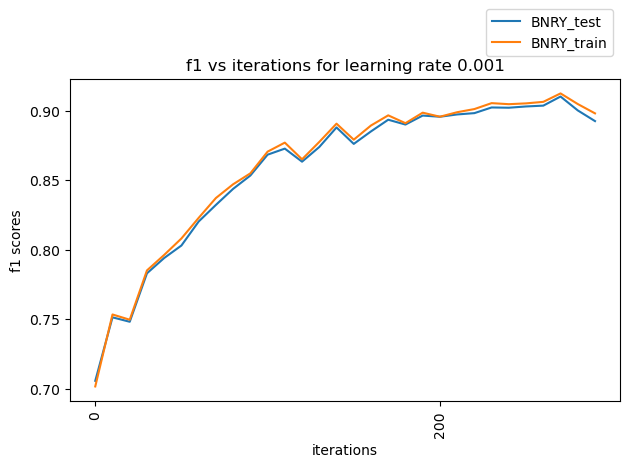

[  0.          10.          20.          30.          40.
  50.          60.          70.          80.          90.
 100.         110.         120.         130.         140.
 150.         160.         170.         180.         190.
 200.         210.         220.         230.         240.
 250.         260.         270.         280.         290.
   0.70154715   0.75337082   0.74959388   0.78509301   0.79626439
   0.80810586   0.82292412   0.83721154   0.84712384   0.8549929
   0.87061788   0.87711035   0.86511483   0.87761349   0.89075895
   0.8792407    0.88944786   0.89674911   0.89111135   0.89867886
   0.89576492   0.89900838   0.90127767   0.90554201   0.90479369
   0.90537532   0.90647216   0.91254803   0.90489388   0.8981844 ]


In [19]:
#ORIG DATASET LR 0.0001 - Adam optimizer with 20 epochs, 500 batch, and RELU, 2 classes
plotPerformance('f1', learning_rate, iter_save)

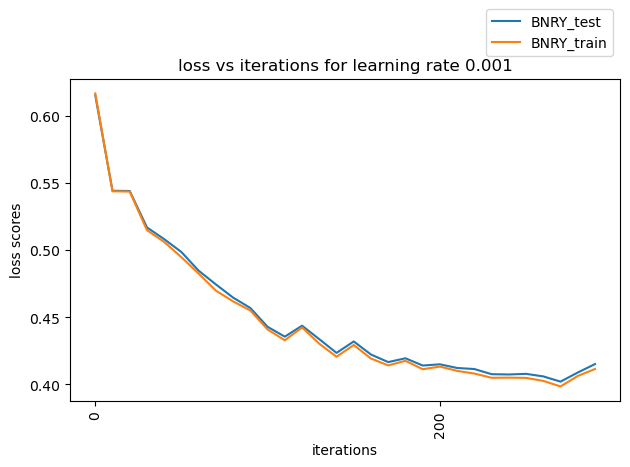

[  0.          10.          20.          30.          40.
  50.          60.          70.          80.          90.
 100.         110.         120.         130.         140.
 150.         160.         170.         180.         190.
 200.         210.         220.         230.         240.
 250.         260.         270.         280.         290.
   0.61692762   0.5439723    0.54377051   0.51501424   0.50624714
   0.49480266   0.48263839   0.46992701   0.46192847   0.45513643
   0.44100624   0.43293573   0.44253278   0.4303807    0.42068858
   0.42943419   0.4193268    0.41422922   0.41765216   0.41137229
   0.41335137   0.41013981   0.40814696   0.40500637   0.40511085
   0.40492085   0.40266903   0.39854795   0.40636526   0.41154768]


In [21]:
#ORIG DATASET LR 0.0001 - Adam optimizer with 20 epochs, 500 batch, and RELU, 2 classes
plotPerformance('loss', learning_rate, iter_save)

In [23]:
##Save the binary model with original data
torch.save(model, "model/BNRYORIG_deepNN.pth")

#Load the saved binary model on orig data
#model = torch.load("model/BNRYORIG_deepNN.pth", weights_only=False)
#model.eval()

### TESTING WITH EXTERNAL DATA ##

In [75]:
#Load the external data

#PRE_PROCESSING MANUAL STEPS BEFORE RUNNING THIS CODE
# 0 IS FAKE; 1 IS REAL
#COPY the "ext_test" folder from /Users/sripriyasundararaman/Desktop/Smriti/Horizon/data/external/real_vs_fake/real-vs-fake
# TO /Users/sripriyasundararaman/Desktop/Smriti/Horizon/data/archive

# RENAME "FAKE" folder to "0" and "REAL" folder to "1"

bnry_ext_test_dataset = torchvision.datasets.ImageFolder(root='./data/archive/ext_test', transform=transform)
bnry_ext_test_loader = torch.utils.data.DataLoader(dataset=bnry_ext_test_dataset, batch_size=batch_size, shuffle=True)

#How many records in test folder
bnry_ext_test_loader.dataset, \
bnry_ext_test_loader.dataset.classes, \
bnry_ext_test_loader.dataset.targets.count(0), \
bnry_ext_test_loader.dataset.targets.count(1)

(Dataset ImageFolder
     Number of datapoints: 20000
     Root location: ./data/archive/ext_test
     StandardTransform
 Transform: Compose(
                ToTensor()
                Resize(size=32, interpolation=bilinear, max_size=None, antialias=True)
            ),
 ['0', '1'],
 10000,
 10000)

0
196608
(256, 256, 3)
torch.Size([3, 32, 32])
tensor(1)


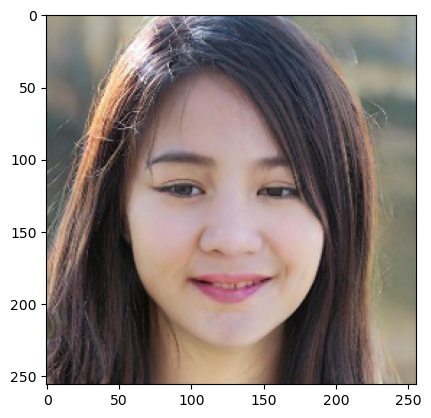

In [129]:
## LOOK AT 1 PICTURE FROM THE EXTERNAL TEST DATA

samp_img_path, samp_label = bnry_ext_test_loader.dataset.imgs[0]
image = imread(samp_img_path)
plt.imshow(image)

print(samp_label)
print(image.size)
print(image.shape)

for test_images, test_labels in bnry_ext_test_loader:  
    sample_image = test_images[0]    
    sample_label = test_labels[0]

print(sample_image.shape)
print(sample_label)

In [142]:
#Load the saved binary model on orig data
model = torch.load("model/BNRYORIG_deepNN.pth", weights_only=False)
model.eval()

f1, acc, loss = test_model(model, bnry_ext_test_loader)
f1, acc, loss

(0.34345155602948435, 0.4909, 0.8160114407539367)

## ELA DATA ONLY ###

In [25]:
ELA_train_dataset = torchvision.datasets.ImageFolder(root='./data/archive2/train', transform=transform)
ELA_test_dataset = torchvision.datasets.ImageFolder(root='./data/archive2/test', transform=transform)

ELA_train_loader = torch.utils.data.DataLoader(dataset=ELA_train_dataset, batch_size=batch_size, shuffle=True)
ELA_test_loader = torch.utils.data.DataLoader(dataset=ELA_test_dataset, batch_size=batch_size, shuffle=True)

# define global map of loader_name to data loaders
loader_map = {
    "ELA_test": ELA_test_loader,
    "ELA_train": ELA_train_loader
}

In [27]:
# Select the model
#model = SimpleCNN().to(device)
start_time = time.time()
model = DeepCNN().to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

results = train_model(model, ELA_train_loader)
end_time = time.time()
elapsed_time_seconds = end_time - start_time
elapsed_time_hours = elapsed_time_seconds / 3600

print(f"Elapsed time: {elapsed_time_hours} hours")

Epoch [1/3], Step [10/200], Loss: 0.6794
Epoch [1/3], Step [20/200], Loss: 0.6007
Epoch [1/3], Step [30/200], Loss: 0.5646
Epoch [1/3], Step [40/200], Loss: 0.5447
Epoch [1/3], Step [50/200], Loss: 0.5289
Epoch [1/3], Step [60/200], Loss: 0.5165
Epoch [1/3], Step [70/200], Loss: 0.5150
Epoch [1/3], Step [80/200], Loss: 0.5195
Epoch [1/3], Step [90/200], Loss: 0.5174
Epoch [1/3], Step [100/200], Loss: 0.5115
Epoch [1/3], Step [110/200], Loss: 0.5071
Epoch [1/3], Step [120/200], Loss: 0.4997
Epoch [1/3], Step [130/200], Loss: 0.5018
Epoch [1/3], Step [140/200], Loss: 0.5037
Epoch [1/3], Step [150/200], Loss: 0.5045
Epoch [1/3], Step [160/200], Loss: 0.5051
Epoch [1/3], Step [170/200], Loss: 0.5113
Epoch [1/3], Step [180/200], Loss: 0.4997
Epoch [1/3], Step [190/200], Loss: 0.4935
Epoch [1/3], Step [200/200], Loss: 0.4910
Epoch [2/3], Step [10/200], Loss: 0.4855
Epoch [2/3], Step [20/200], Loss: 0.4894
Epoch [2/3], Step [30/200], Loss: 0.4882
Epoch [2/3], Step [40/200], Loss: 0.4840
Epoch

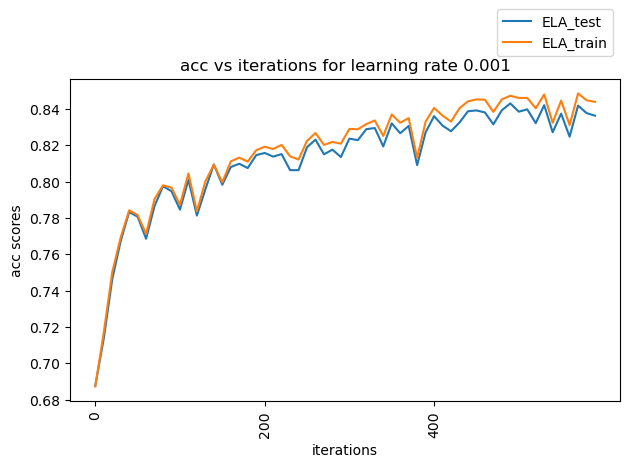

[  0.       10.       20.       30.       40.       50.       60.
  70.       80.       90.      100.      110.      120.      130.
 140.      150.      160.      170.      180.      190.      200.
 210.      220.      230.      240.      250.      260.      270.
 280.      290.      300.      310.      320.      330.      340.
 350.      360.      370.      380.      390.      400.      410.
 420.      430.      440.      450.      460.      470.      480.
 490.      500.      510.      520.      530.      540.      550.
 560.      570.      580.      590.        0.6873    0.71685   0.75003
   0.76929   0.7842    0.78158   0.77118   0.79048   0.79794   0.79667
   0.7872    0.80449   0.78366   0.80012   0.80935   0.79959   0.81114
   0.81316   0.811     0.81726   0.81919   0.81794   0.82019   0.81391
   0.81211   0.82242   0.82673   0.82018   0.82179   0.82087   0.82897
   0.82879   0.83163   0.83363   0.82511   0.8369    0.83238   0.83494
   0.8131    0.83297   0.84053   0.83627   0.8

In [28]:
#ELA DATASET LR 0.001 - Adam optimizer with 2 epochs, 1000 batch, and RELU, 2 classes
plotPerformance('acc', learning_rate, iter_save)

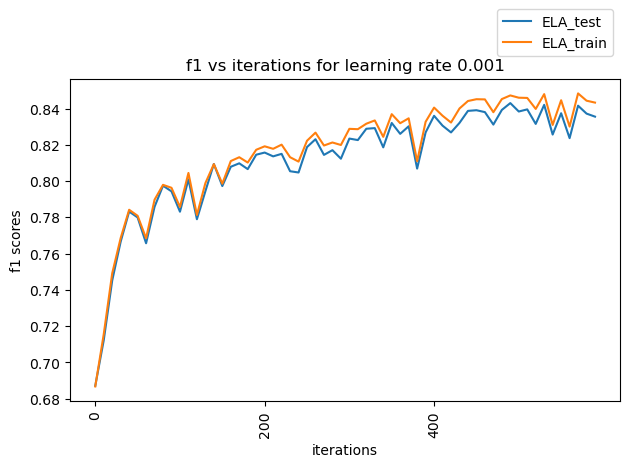

[  0.          10.          20.          30.          40.
  50.          60.          70.          80.          90.
 100.         110.         120.         130.         140.
 150.         160.         170.         180.         190.
 200.         210.         220.         230.         240.
 250.         260.         270.         280.         290.
 300.         310.         320.         330.         340.
 350.         360.         370.         380.         390.
 400.         410.         420.         430.         440.
 450.         460.         470.         480.         490.
 500.         510.         520.         530.         540.
 550.         560.         570.         580.         590.
   0.68676727   0.71554743   0.7491392    0.76857948   0.78417824
   0.78085798   0.76846637   0.78972553   0.79792312   0.79629036
   0.78571452   0.8044788    0.78129816   0.7988551    0.809335
   0.79855468   0.81103635   0.81314466   0.81022023   0.81725084
   0.81916495   0.81778697   0.82008174   

In [29]:
#ELA DATASET LR 0.001 - Adam optimizer with 2 epochs, 1000 batch, and RELU, 2 classes
plotPerformance('f1', learning_rate, iter_save)

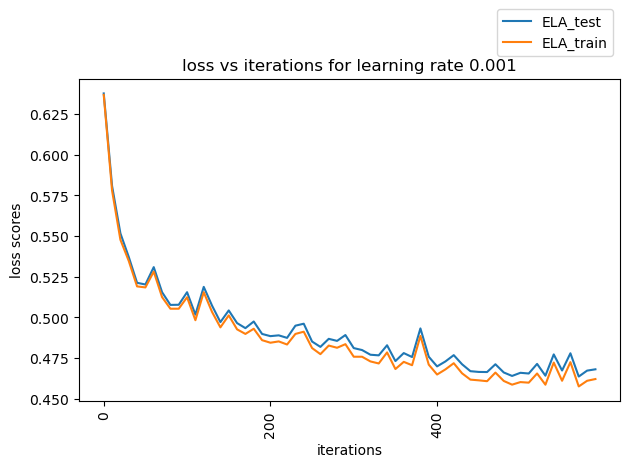

[0.00000000e+00 1.00000000e+01 2.00000000e+01 3.00000000e+01
 4.00000000e+01 5.00000000e+01 6.00000000e+01 7.00000000e+01
 8.00000000e+01 9.00000000e+01 1.00000000e+02 1.10000000e+02
 1.20000000e+02 1.30000000e+02 1.40000000e+02 1.50000000e+02
 1.60000000e+02 1.70000000e+02 1.80000000e+02 1.90000000e+02
 2.00000000e+02 2.10000000e+02 2.20000000e+02 2.30000000e+02
 2.40000000e+02 2.50000000e+02 2.60000000e+02 2.70000000e+02
 2.80000000e+02 2.90000000e+02 3.00000000e+02 3.10000000e+02
 3.20000000e+02 3.30000000e+02 3.40000000e+02 3.50000000e+02
 3.60000000e+02 3.70000000e+02 3.80000000e+02 3.90000000e+02
 4.00000000e+02 4.10000000e+02 4.20000000e+02 4.30000000e+02
 4.40000000e+02 4.50000000e+02 4.60000000e+02 4.70000000e+02
 4.80000000e+02 4.90000000e+02 5.00000000e+02 5.10000000e+02
 5.20000000e+02 5.30000000e+02 5.40000000e+02 5.50000000e+02
 5.60000000e+02 5.70000000e+02 5.80000000e+02 5.90000000e+02
 6.36833024e-01 5.78015512e-01 5.47771023e-01 5.34770255e-01
 5.19081116e-01 5.184509

In [30]:
#ELA DATASET LR 0.001 - Adam optimizer with 2 epochs, 1000 batch, and RELU, 2 classes
plotPerformance('loss', learning_rate, iter_save)

In [37]:
##Save the binary model with original data
torch.save(model, "model/ELA_deepNN.pth")

#Load the saved binary model on orig data
#model = torch.load("model/BNRY_deepNN_origData.pth", weights_only=False)
#model.eval()

### TESTING WITH EXTERNAL DATA

In [155]:
#convert external files into ELA

convert_files("data/archive/ext_test/0", "data/archive2/ext_test/0")
convert_files("data/archive/ext_test/1", "data/archive2/ext_test/1")

In [157]:
#Load the external data

ela_ext_test_dataset = torchvision.datasets.ImageFolder(root='./data/archive2/ext_test', transform=transform)
ela_ext_test_loader = torch.utils.data.DataLoader(dataset=ela_ext_test_dataset, batch_size=batch_size, shuffle=True)

#How many records in external test folder
ela_ext_test_loader.dataset, \
ela_ext_test_loader.dataset.classes, \
ela_ext_test_loader.dataset.targets.count(0), \
ela_ext_test_loader.dataset.targets.count(1)

(Dataset ImageFolder
     Number of datapoints: 20000
     Root location: ./data/archive2/ext_test
     StandardTransform
 Transform: Compose(
                ToTensor()
                Resize(size=32, interpolation=bilinear, max_size=None, antialias=True)
            ),
 ['0', '1'],
 10000,
 10000)

0
196608
(256, 256, 3)
torch.Size([3, 32, 32])
tensor(1)


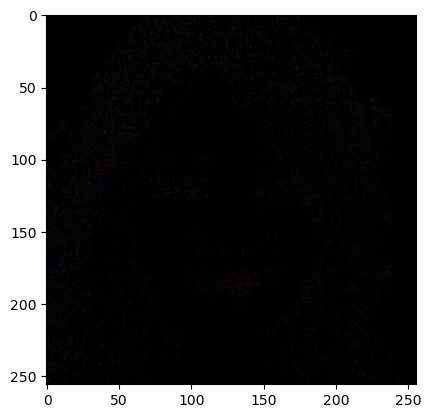

In [159]:
## LOOK AT 1 PICTURE FROM THE EXTERNAL TEST DATA

samp_img_path, samp_label = ela_ext_test_loader.dataset.imgs[0]
image = imread(samp_img_path)
plt.imshow(image)

print(samp_label)
print(image.size)
print(image.shape)

for test_images, test_labels in ela_ext_test_loader:  
    sample_image = test_images[0]    
    sample_label = test_labels[0]

print(sample_image.shape)
print(sample_label)

In [161]:
#Load the saved binary model on orig data
model = torch.load("model/ELA_deepNN.pth", weights_only=False)
model.eval()

f1, acc, loss = test_model(model, bnry_ext_test_loader)
f1, acc, loss

(0.33391050430063435, 0.5001, 0.8130369186401367)